In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

In [ ]:
pd.set_option('display.max_columns',None)
df_bell = pd.read_csv('/kaggle/input/epitope-prediction/input_bcell.csv')
df_sars = pd.read_csv('/kaggle/input/epitope-prediction/input_sars.csv')
df_covid = pd.read_csv('/kaggle/input/epitope-prediction/input_covid.csv')
df_bell.head()

In [ ]:
df_bellsars = pd.concat([df_bell,df_sars],axis = 0)
df_bellsars.head()

In [ ]:
df_bellsars = df_bellsars.sample(frac=1).reset_index(drop=True)
df_bellsars.head()

In [ ]:
df_bellsars = df_bellsars.drop(['parent_protein_id','protein_seq','peptide_seq'],axis = 1)
df_bellsars.head()

In [ ]:
sn.countplot(data=df_bellsars,x = 'target',palette='plasma')

In [ ]:
plt.figure(figsize=(16,9))
sn.heatmap(df_bellsars.corr(),annot=True,linecolor='red',linewidths=3,cmap = 'plasma')

In [ ]:
df = df_bellsars.copy()

test = df['target']

train = df.drop(['target'],axis = 1)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
ec = ExtraTreesClassifier()
ec.fit(train,test)


In [ ]:
ec_series = pd.Series(ec.feature_importances_,index=train.columns)
ec_series.plot(kind = 'barh',color = 'magenta')

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV,train_test_split,cross_val_score
from sklearn import metrics

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train,test,test_size = 0.2)

# RANDOM FOREST 🎄 AND XGBOOST💥

In [ ]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)
#plt.figure(figsize=(16,9))
#tree.plot_tree(clf,filled=True,class_names=['has','does not have'],feature_names=train.columns)

In [ ]:
path = clf.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas = path.ccp_alphas

In [ ]:
alpha_list = []
for i in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0,ccp_alpha=i)
    clf.fit(X_train,y_train)
    alpha_list.append(clf)

In [ ]:
train_score = [clf.score(X_train,y_train) for clf in alpha_list]
test_score = [clf.score(X_test,y_test) for clf in alpha_list]

plt.plot(ccp_alphas,train_score,label = 'Training',color = 'red',marker = 'o',drawstyle = 'steps-post')
plt.plot(ccp_alphas,test_score,label = 'Testing',color = 'black',marker = '+',drawstyle = 'steps-post')
plt.legend()
plt.show()

In [ ]:
params = {
    'RandomForest':{
        'model':RandomForestClassifier(),
        'params':{
            'n_estimators' : [int(x) for x in np.linspace(100,1200,10)],
            'max_depth': [int(x) for x in np.linspace(1,50,10)],
            'min_samples_split': [1,2,5,10],
            'min_samples_leaf': [1,2,5,10],
            'ccp_alpha':[0.0025,0.0030,0.0045,0.005],
            'criterion':['gini','entropy'],
        }
    },
}

In [ ]:
score = []
for model_name,mp in params.items():
    clf = RandomizedSearchCV(mp['model'],param_distributions=mp['params'],cv = 5,n_iter=10,scoring='accuracy',verbose=2)
    clf.fit(X_train,y_train)
    score.append({
        'model_name':model_name,
        'best_score':clf.best_score_,
        'best_estimator':clf.best_estimator_,
    })

In [ ]:
score_df = pd.DataFrame(score,columns=['model_name','best_score','best_estimator'])
score_df

In [ ]:
for i in score_df['best_estimator']:
    print(i)
    print("="*100)

In [ ]:
rf = RandomForestClassifier(ccp_alpha=0.0025, criterion='entropy', max_depth=39,
                       min_samples_leaf=2, n_estimators=711)
rf.fit(X_train,y_train)
rf.score(X_test,y_test)

In [ ]:
dt = DecisionTreeClassifier(ccp_alpha=0.0025)
dt.fit(X_train,y_train)
plt.figure(figsize=(16,9))
tree.plot_tree(dt,filled=True,feature_names=train.columns,class_names=['has','does not have'])

# »XGBOOST MODEL:

-------> I've trained the model on Google colab,here's a jist of the parameters

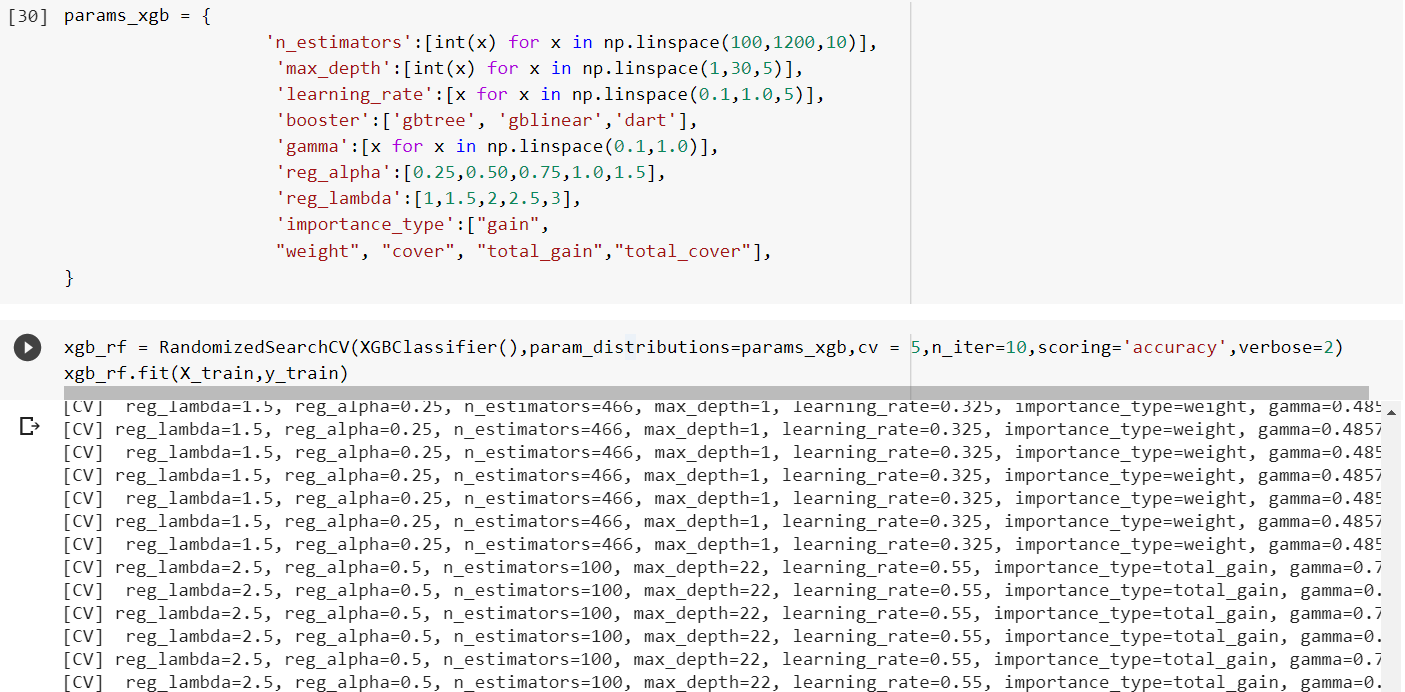

In [ ]:
xgb = XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.7795918367346939,
              learning_rate=0.325, max_delta_step=0, max_depth=22,
              min_child_weight=1, missing=None, n_estimators=833, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.25, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
xgb.fit(X_train,y_train)
xgb.score(X_train,y_train)

In [ ]:
xgb.score(X_test,y_test)

In [ ]:
y_predxgb = xgb.predict(X_test)
y_predxgb = np.array(y_predxgb)
y_testxgb = np.array(y_test)
xgb_actual = pd.DataFrame(y_testxgb)
xgb_predicted = pd.DataFrame(y_predxgb)
xgb_df = pd.concat([xgb_actual,xgb_predicted],axis = 1)
xgb_df.columns = ['Actual','Predicted']
xgb_df

In [ ]:
for i in xgb_df.columns:
    print(f' count of <{i}> ia {xgb_df[i].value_counts()}')
    print("="*100)

In [ ]:
sn.countplot(data = xgb_df,x = 'Predicted',palette='plasma')


In [ ]:
sn.countplot(data = xgb_df,x = 'Actual',palette='plasma')


In [ ]:
metrics.plot_confusion_matrix(xgb,X_test,y_test,cmap='inferno',display_labels=['Covid -ve','Covid +ve'])


# »Random Forest

In [ ]:
y_predrf = rf.predict(X_test)
y_predrf = np.array(y_predrf)
y_testrf = np.array(y_test)
rf_actual = pd.DataFrame(y_testrf)
rf_predict = pd.DataFrame(y_predrf)
rf_df = pd.concat([rf_actual,rf_predict],axis = 1)
rf_df.columns = ['Actual','Predicted']

In [ ]:
for i in rf_df.columns:
    print(f' count of <{i}> ia {rf_df[i].value_counts()}')
    print("="*100)

In [ ]:
sn.countplot(data = rf_df,x = 'Predicted',palette='plasma')


In [ ]:
sn.countplot(data = rf_df,x = 'Actual',palette='plasma')


In [ ]:
metrics.plot_confusion_matrix(rf,X_test,y_test,cmap = 'plasma',display_labels=['Covid +ve','Covid -ve'])

In [ ]:
rf_report = metrics.classification_report(y_test,y_predrf)
xgb_report = metrics.classification_report(y_test,y_predxgb)
print(f' report of RandomForest is {rf_report}\n\n report of XGBmodel is {xgb_report}')

## XGboost has performed better than Random Forest overall,well lets see the Neural Network Implementation

In [ ]:
mm = MinMaxScaler()

In [ ]:
X_train_mm = mm.fit_transform(X_train)
X_test_mm = mm.transform(X_test)

In [ ]:
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import  Sequential

In [ ]:
model = Sequential()
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

In [ ]:
r_mm = model.fit(X_train_mm,y_train,epochs = 100,validation_data=(X_test_mm,y_test))

In [ ]:
plt.plot(r_mm.history['loss'],label = 'loss',color = 'red')
plt.plot(r_mm.history['val_loss'],label = 'validation_loss',color = 'blue')
plt.legend()
plt.show()

In [ ]:
plt.plot(r_mm.history['accuracy'],label = 'loss',color = 'red')
plt.plot(r_mm.history['val_accuracy'],label = 'validation_accuarcy',color = 'blue')
plt.legend()
plt.show()

In [ ]:
prediction = model.predict(X_test_mm)

In [ ]:
prediction = (prediction > 0.5)

In [ ]:
print(metrics.classification_report(y_test, prediction, target_names = ['Covid_Negative','Covid_Positive']))

In [ ]:
cn = metrics.confusion_matrix(y_test,prediction)
sn.heatmap(cn,annot=True,xticklabels=['Covid -ve','Covid +ve'],yticklabels=['Covid -ve','Covid +ve'],cmap = 'plasma')

## Let's test for the testing Dataframe i.e the Covid.csv

In [ ]:
df_covid = df_covid.drop(['parent_protein_id', 'protein_seq','peptide_seq'],axis = 1)
df_covid.head(3)



In [ ]:
df_covid = mm.transform(df_covid)


In [ ]:
prediction_class = model.predict_classes(df_covid)
prediction_class

In [ ]:
predictions_covid = pd.DataFrame(prediction_class,columns=['predicted_class'])

In [ ]:
predictions_covid.head()

In [ ]:
cn = metrics.confusion_matrix(y_test,prediction)
sn.heatmap(cn,annot=True,linecolor='red',linewidths=3,xticklabels=['Covid -ve','Covid +ve'],yticklabels=['Covid -ve','Covid +ve'],cmap='plasma')

In [ ]:
sn.countplot(data = predictions_covid,x = 'predicted_class',palette='plasma')

In [ ]:
predictions_covid['predicted_class'].value_counts()

In [ ]:
print(metrics.classification_report(y_test, prediction, target_names = ['Covid_Negative','Covid_Positive']))

#### As We can see that Our ANN model predicted 19k+ as COVID (-ve) and 500-530 as Covid (+ve)..as we can see from the classification report above,the model has an accuracy of 80% 
#### Xgboost model resulted in overfitting the data,so i used the ANN model and Random Forest did'nt show results as the ANN model did,so i selected the ANN model :)